**QUESTION 1: CALL CENTER DATA SET - EXPONENTIAL LIKELIHOOD WITH GAMMA PRIOR**

In [34]:
import pystan
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Load the data set containing durations between calls arriving at the call center.
# All values are in minutes.
waiting_times_day = np.loadtxt('call_center.csv')

# Split the data into 24 separate series, one for each hour of the day
current_time = 0
waiting_times_per_hour = [[] for _ in range(24)]  # Make 24 empty lists, one per hour
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)

# Data for Stan model
hour11 = {
    'waiting_times' : waiting_times_per_hour[11],
    'alpha' : 1,
    'beta' : 0.25,
    'count': len(waiting_times_per_hour[11]),
}


In [35]:
# Stan model
stan_code = """

data {
    int<lower=0> count;
    real<lower=0> waiting_times[count];
    real<lower=0> alpha;  
    real<lower=0> beta;   
   
}

parameters {
    real<lower=0> lambda;
}

model {
    lambda ~ gamma(alpha,beta);    
    for (i in 1: count){
        waiting_times[i] ~ exponential(lambda);
    } 
}

"""

In [36]:
# Compile Stan model
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_11407b0c7d27ab3bd8ff620938a1c7dd NOW.


In [37]:
# Fit the model to the data.
results = stan_model.sampling(data=hour11)

# Extract the samples generated by Stan
samples = results.extract()

Posterior 95% confidence interval for lambda: [13.92476684 15.81172305]


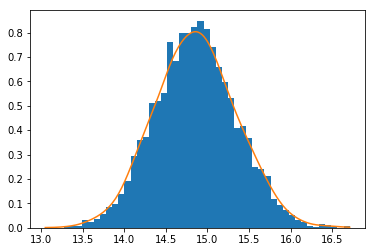

In [40]:
# Compute 95% posterior confidence intervals for lambda
lambda_conf = np.percentile(samples['lambda'], [2.5, 97.5])

# Plot lambda histogram (Kernel density plot)
print("Posterior 95% confidence interval for lambda:", lambda_conf)

plot = samples['lambda']
density = gaussian_kde(plot)
xs = np.linspace(min(plot), max(plot), 200)
plt.hist(plot, bins=50, density=True)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs))
plt.show()